In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

In [5]:
innov_dim = 1000

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [7]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,5.523276,-0.229847
vol,-0.229847,1.886587


In [9]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [10]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


In [11]:
stats.describe(data)

DescribeResult(nobs=3713, minmax=(array([-20.782,   0.123]), array([ 18.031, 421.881])), mean=array([0.023, 5.621]), variance=array([  5.523, 209.047]), skewness=array([-0.312, 12.209]), kurtosis=array([ 10.066, 240.401]))

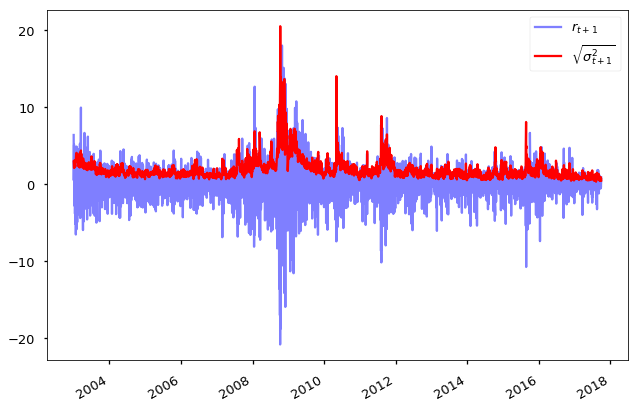

In [12]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

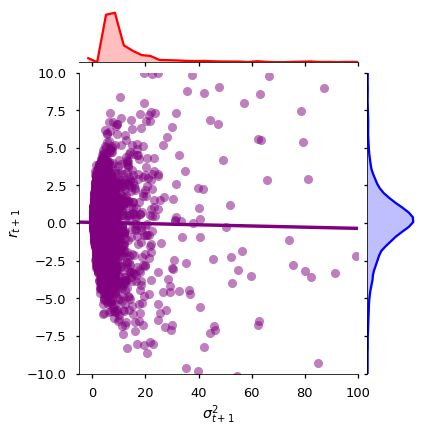

In [21]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data, xlim=[-5, 100], ylim=[-10, 10])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [22]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [23]:
vl.compute_init_constants(data.vol)

{'log_both': 0.37463265375235344,
 'log_scale': 2.265603174187479,
 'rho': 0.7409169043125318}

In [24]:
vl.compute_vol_gmm(data.vol, vl.compute_init_constants(data.vol))

({'log_both': 0.9068982998540172,
  'log_scale': 1.8030412407446503,
  'rho': 0.5170973517357483},
            log_both  log_scale       rho
 log_both   0.045039   0.039444 -0.023642
 log_scale  0.039444   0.081291 -0.017686
 rho       -0.023642  -0.017686  0.012850)

In [25]:
estimates, covariance = vl.estimate_params(data, *vl.compute_vol_gmm(data.vol, vl.compute_init_constants(data.vol))) 
                                           


In [26]:
estimates

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'log_both': 0.9068982998540172,
 'log_scale': 1.8030412407446503,
 'rho': 0.5170973517357483}

In [27]:
vl.compute_strong_id(estimates, covariance)

({'phi': -0.2909416706212783, 'pi': 0.0, 'theta': 0.4279405754405017},
             phi        pi     theta
 phi    0.016565 -0.000819 -0.004891
 pi    -0.000819  0.000888 -0.000092
 theta -0.004891 -0.000092  0.001779)

In [28]:
vl.estimate_params_strong_id(data) #,  bounds=[(-3, 2), (-1, 3), (0,1)])

({'gamma': 0.25965685942691796,
  'beta': 0.1113552770767416,
  'psi': -0.15373902507632284,
  'zeta': 0.9086856628806307,
  'log_both': 0.9068982998540172,
  'log_scale': 1.8030412407446503,
  'rho': 0.5170973517357483,
  'phi': -0.29095171569868855,
  'pi': 0.0,
  'theta': 0.4279403644449851},
                beta     gamma  log_both  log_scale       phi        pi  \
 beta       0.000097 -0.000035  0.000000   0.000000       NaN       NaN   
 gamma     -0.000035  0.000648  0.000000   0.000000       NaN       NaN   
 log_both   0.000000  0.000000  0.045039   0.039444       NaN       NaN   
 log_scale  0.000000  0.000000  0.039444   0.081291       NaN       NaN   
 phi             NaN       NaN       NaN        NaN  0.016565 -0.000819   
 pi              NaN       NaN       NaN        NaN -0.000819  0.000888   
 psi       -0.000091 -0.000080  0.000000   0.000000       NaN       NaN   
 rho        0.000000  0.000000 -0.023642  -0.017686       NaN       NaN   
 theta           NaN       N

In [29]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'log_both': 0.9068982998540172,
 'log_scale': 1.8030412407446503,
 'rho': 0.5170973517357483,
 'phi': -0.29093720869824036,
 'pi': -2.8982376910040834e-10,
 'theta': 0.42793546199859617}

In [30]:
pd.Series(omega)

gamma        2.596569e-01
beta         1.113553e-01
psi         -1.537390e-01
zeta         9.086857e-01
log_both     9.068983e-01
log_scale    1.803041e+00
rho          5.170974e-01
phi         -2.909372e-01
pi          -2.898238e-10
theta        4.279355e-01
dtype: float64

In [31]:
omega_cov

,beta,gamma,log_both,log_scale,phi,pi,psi,rho,theta,zeta
beta,0.000097,-0.000035,0.000000,0.000000,NaN,NaN,-0.000091,0.000000,NaN,0.000000
gamma,-0.000035,0.000648,0.000000,0.000000,NaN,NaN,-0.000080,0.000000,NaN,0.000000
log_both,0.000000,0.000000,0.045039,0.039444,NaN,NaN,0.000000,-0.023642,NaN,0.000000
log_scale,0.000000,0.000000,0.039444,0.081291,NaN,NaN,0.000000,-0.017686,NaN,0.000000
phi,NaN,NaN,NaN,NaN,0.016564,-0.000818,NaN,NaN,-0.004891,NaN
pi,NaN,NaN,NaN,NaN,-0.000818,0.000888,NaN,NaN,-0.000092,NaN
psi,-0.000091,-0.000080,0.000000,0.000000,NaN,NaN,0.000149,0.000000,NaN,0.000000
rho,0.000000,0.000000,-0.023642,-0.017686,NaN,NaN,0.000000,0.012850,NaN,0.000000
theta,NaN,NaN,NaN,NaN,-0.004891,-0.000092,NaN,NaN,0.001779,NaN
zeta,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,NaN,0.000431


In [32]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.123335
2017-09-14    0.214673
2017-09-22    0.216867
2016-11-25    0.226227
2017-07-24    0.242692
Name: vol, dtype: float64

In [33]:
omega2, omega_cov2 = vl.estimate_params(data)

In [34]:
omega2

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'log_both': 0.9068982998540172,
 'log_scale': 1.8030412407446503,
 'rho': 0.5170973517357483}

In [35]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                                 pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,  use_tqdm=True)
                               


In [36]:
qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                               innov_dim=innov_dim, pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,
                               use_tqdm=True, alpha=0.05)

In [37]:
np.sort(qlr_stats.phi.unique()) - np.sort(qlr_draws.phi.unique())

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
qlr_stats.set_index(['phi', 'pi', 'theta']).head()

qlr
phi  pi    theta        
-0.9 -0.25 0.466667  inf
           0.200000  inf
           0.288889  inf
           0.244444  inf
           0.333333  inf

In [39]:
qlr_stats.count()

phi      1000
pi       1000
theta    1000
qlr      1000
dtype: int64

In [40]:
qlr_stats.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
qlr_draws.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
close_enough = np.allclose(qlr_stats[['phi', 'pi', 'theta']], qlr_draws[['phi', 'pi', 'theta']])

if not close_enough:
    raise RuntimeError('The indices are not the same!!!')
    
else:
    qlr_stats[['phi', 'pi', 'theta']] = qlr_draws[['phi', 'pi', 'theta']]
    
    
merged_values = pd.merge(qlr_stats, qlr_draws,left_on=['phi', 'pi', 'theta'], right_on=['phi', 'pi', 'theta'],
                         suffixes=['_draws', '_stats'])

In [41]:
qlr_stats.sort_values(by='qlr')

,phi,pi,theta,qlr
963,0.0,-0.083333,0.511111,0.000000
693,-0.2,-0.250000,0.200000,0.462411
796,-0.2,0.000000,0.288889,6.969082
696,-0.2,-0.250000,0.288889,8.254866
794,-0.1,-0.250000,0.244444,8.989194
786,-0.2,-0.027778,0.288889,13.178839
886,-0.1,0.000000,0.288889,14.064222
596,-0.3,-0.250000,0.288889,14.627980
894,0.0,-0.250000,0.244444,14.849222
695,-0.3,0.000000,0.422222,16.772347


In [42]:
qlr_draws.sort_values(by='qlr')

,phi,pi,theta,qlr
3,-0.9,-0.250000,0.200000,0.000000
613,-0.3,-0.222222,0.555556,0.000000
614,-0.3,-0.222222,0.600000,0.000000
615,-0.3,-0.194444,0.200000,0.000000
616,-0.3,-0.194444,0.244444,0.000000
617,-0.3,-0.194444,0.288889,0.000000
618,-0.3,-0.194444,0.333333,0.000000
619,-0.3,-0.194444,0.377778,0.000000
620,-0.3,-0.194444,0.422222,0.000000
621,-0.3,-0.194444,0.466667,0.000000


In [43]:
merged_values

,phi,pi,theta,qlr_draws,qlr_stats
0,-0.9,-0.250000,0.511111,inf,0.000000
1,-0.9,-0.250000,0.200000,inf,0.000000
2,-0.9,-0.250000,0.244444,inf,0.000000
3,-0.9,-0.250000,0.466667,inf,0.000000
4,-0.9,-0.250000,0.377778,inf,0.000000
5,-0.9,-0.250000,0.288889,inf,0.000000
6,-0.9,-0.250000,0.333333,inf,0.000000
7,-0.9,-0.250000,0.422222,inf,0.000000
8,-0.9,-0.250000,0.555556,inf,0.000000
9,-0.9,-0.222222,0.200000,inf,0.000000


In [44]:
accepted_vals = merged_values.query('qlr_stats > qlr_draws').drop(['qlr_draws', 'qlr_stats'], axis='columns')

In [45]:
# qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region.json')

In [46]:
qlr_draws = pd.read_json('../results/qlr_draws_on_data_250_smaller_region.json')

In [47]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [48]:
accepted_vals

,phi,pi,theta
795,-0.2,0.0,0.288889


In [50]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'log_both': 0.9068982998540172,
 'log_scale': 1.8030412407446503,
 'rho': 0.5170973517357483,
 'phi': -0.29093720869824036,
 'pi': -2.8982376910040834e-10,
 'theta': 0.42793546199859617}

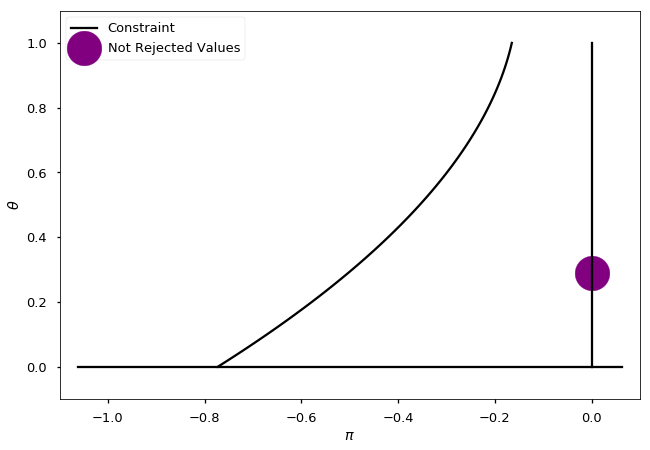

In [51]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=1200, label='Not Rejected Values',
           color='purple')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,1,100)
xvals = [constraint(np.exp(omega['log_scale']), omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='black', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axvline(-15,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.axhline(5,  xmin=.5 /16, xmax=1 - .5/16, color='black')

ax3.set_ylabel(r'$\theta$')
ax3.set_xlabel(r'$\pi$')
ax3.set_ylim([-0.1, 1.1])
ax3.set_xlim([-1.1, 0.1])
ax3.legend()

fig3.savefig('../doc/figures/confidence_region.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [52]:
accepted_vals.min()

phi     -0.200000
pi       0.000000
theta    0.288889
dtype: float64

In [53]:
accepted_vals.max()

phi     -0.200000
pi       0.000000
theta    0.288889
dtype: float64